# aiReview

aiReview is an artificial intelligence-based system that creates a reviewer (in the form of an HTML file) from handwritten lecture notes. It uses optical character recognition (OCR) in converting an image of handwritten text into a machine-readable text file. Unlike other OCR software, it also features an annotation-conversion system that converts underlined words in the input with blanks and encircled words into bolded words.

This project is developed by: 

- A.V. Cayetano (THX)
- J. M. Choa (THX)
- H. A. Macalisang (THU)
- R. J. Portuguez (THW)

Thematic inspiration:
SDG 4 – Quality Education.

## Import packages

In [2]:
import numpy as np
import pandas as pd
import scipy
import cv2
from matplotlib import pyplot as plt
import ipynb.fs.defs.utils as utils
from PIL import Image
from IPython.display import display
from scipy.ndimage import interpolation

## Methodology

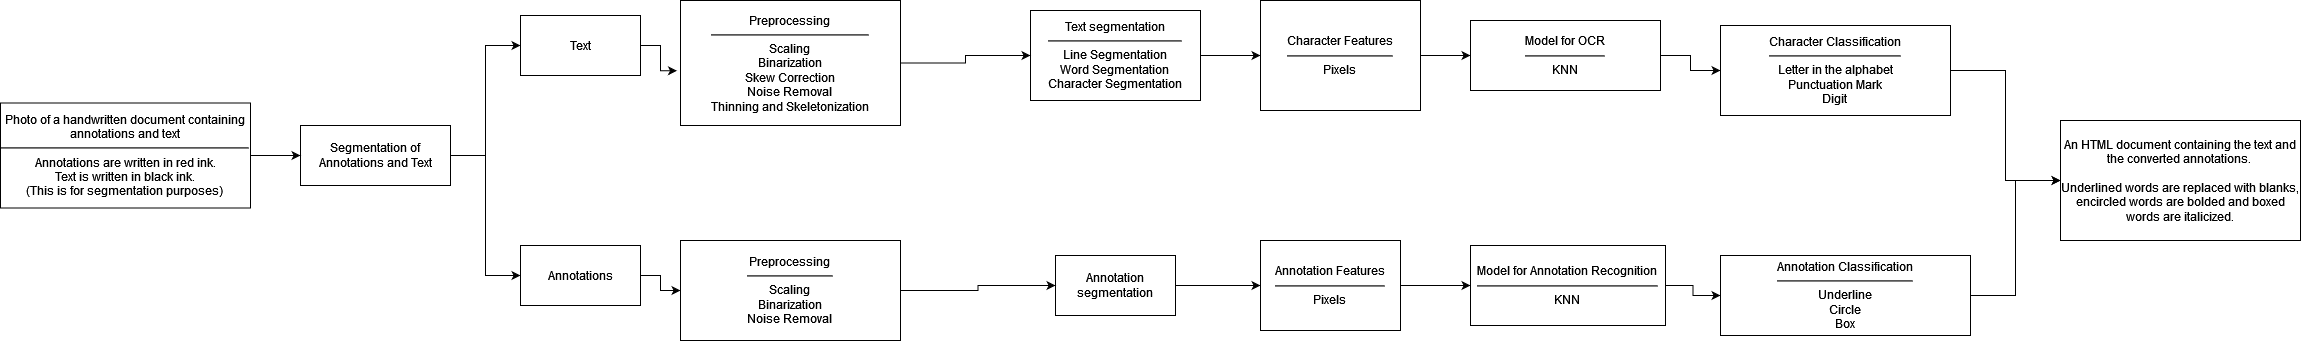

In [3]:
with Image.open("../media/method.png") as method_img:
    display(method_img)
    
    

# The image below is not updated. Will update soon.
 


## Load Data

(336, 731)
1087 500


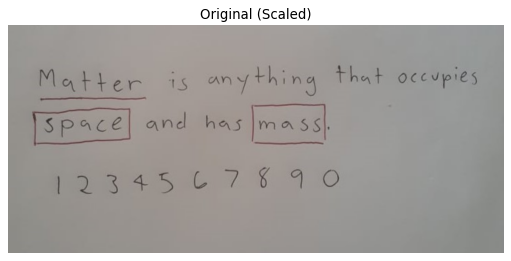

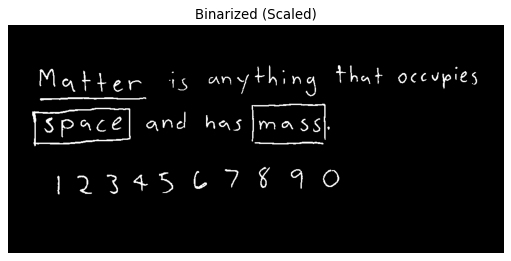

In [4]:
# load dataset here



# load test data here
# test_img = cv2.imread("../input/test_6.png")
test_img = cv2.imread("../input/test_4.png") # try this for more realistic image


def rescale(img):
    dim = img.shape[:-1]
    print(dim)
    ratio = dim[1] / dim[0]
    target_height = int(500)
    target_width = int(target_height * ratio)
    print(target_width, target_height)
    return cv2.resize(img, (target_width, target_height))

test_img = rescale(test_img)


test_img_gs = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
_, test_img_bin = cv2.threshold(test_img_gs, 127, 255, cv2.THRESH_BINARY_INV)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_hsv = cv2.cvtColor(test_img, cv2.COLOR_BGR2HSV)
utils.plot_img_rgb(test_img_rgb, "Original (Scaled)")
# utils.plot_img_rgb(cv2.cvtColor(test_img_gs, cv2.COLOR_GRAY2RGB), "")
utils.plot_img_rgb(cv2.cvtColor(test_img_bin, cv2.COLOR_GRAY2RGB), "Binarized (Scaled)")

## Segmentation of Annotations and Text and Noise Removal

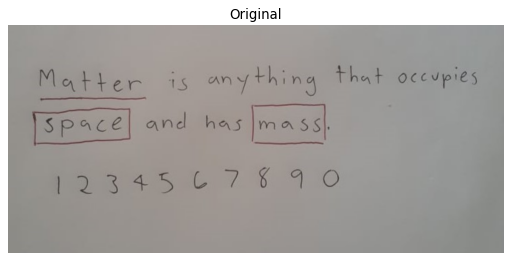

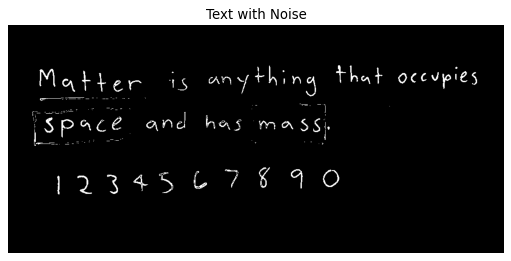

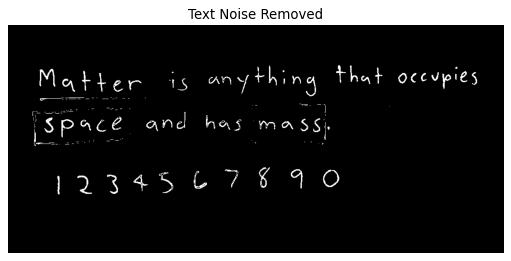

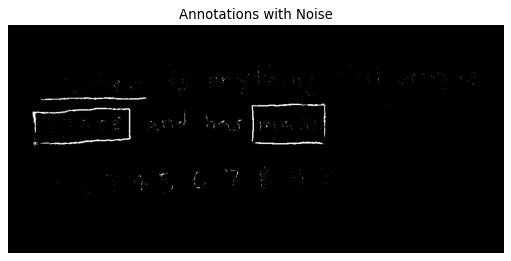

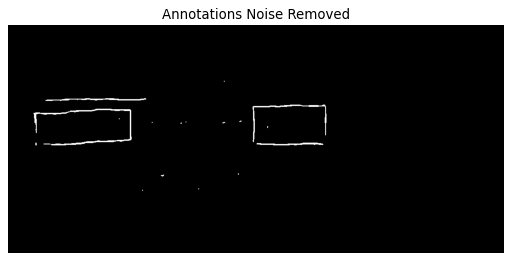

In [5]:
# References:
# https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html
# https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

# This function uses masks to segment
def get_text(test_img):
    # filter all black inks
     # problem: we need to find the appropriate values for these limits
    lower_text_color = np.array([0, 0, 0])
    upper_text_color = np.array([179, 44, 130])
    text_img = cv2.inRange(test_img, lower_text_color, upper_text_color)

    return text_img

def remove_noise(text_img_bin, kernel_size_open=(1, 1), kernel_size_close=(1, 1)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)
    text_img_bin = cv2.morphologyEx(text_img_bin, cv2.MORPH_OPEN, kernel_open)
    text_img_bin = cv2.morphologyEx(text_img_bin, cv2.MORPH_CLOSE, kernel_close)
    
    return text_img_bin


def get_annotations(test_img_bin, text_img_bin):
    # filter all inks that are not text
    annotations_img = cv2.bitwise_xor(test_img_bin, text_img_bin)
    return annotations_img

utils.plot_img_rgb(test_img_rgb, "Original")

text_img_bin = get_text(test_img_hsv)

utils.plot_img_rgb(cv2.cvtColor(text_img_bin, cv2.COLOR_GRAY2RGB), "Text with Noise")

text_img_bin = remove_noise(text_img_bin)


utils.plot_img_rgb(cv2.cvtColor(text_img_bin, cv2.COLOR_GRAY2RGB), "Text Noise Removed")

annotations_img_bin = get_annotations(test_img_bin, text_img_bin)

utils.plot_img_rgb(cv2.cvtColor(annotations_img_bin, cv2.COLOR_GRAY2RGB), "Annotations with Noise")

annotations_img_bin = remove_noise(annotations_img_bin, (2, 2), (8, 8))



utils.plot_img_rgb(cv2.cvtColor(annotations_img_bin, cv2.COLOR_GRAY2RGB), "Annotations Noise Removed")


## Skew Correction

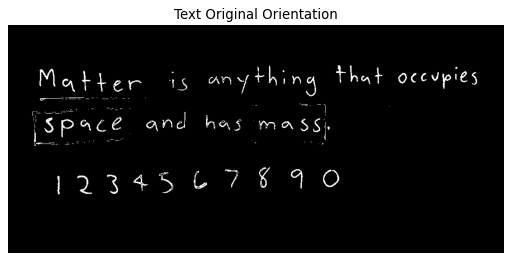

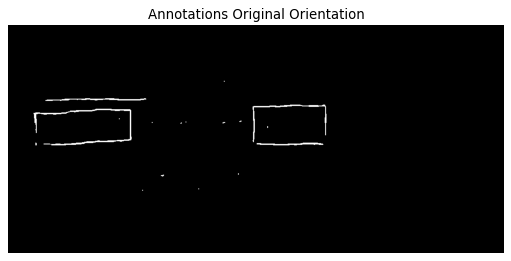

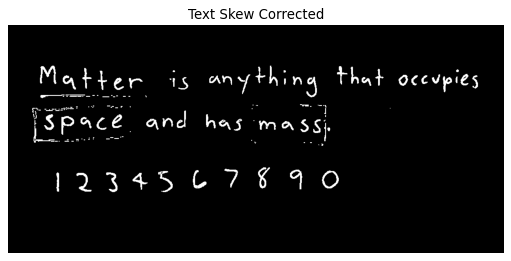

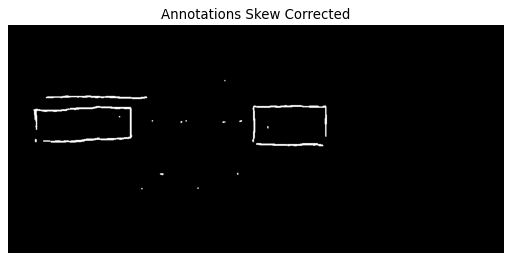

In [6]:
# References:
# https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
# https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html

utils.plot_img_rgb(cv2.cvtColor(text_img_bin, cv2.COLOR_GRAY2RGB), "Text Original Orientation")
utils.plot_img_rgb(cv2.cvtColor(annotations_img_bin, cv2.COLOR_GRAY2RGB), "Annotations Original Orientation")

coords = np.column_stack(np.where(text_img_bin > 0))
angle = cv2.minAreaRect(coords)[-1]


if angle > 45:
    angle = 90 - angle
else:
    angle = -angle

rows, cols = text_img_bin.shape
rotation = cv2.getRotationMatrix2D(((cols-1)/2, (rows-1)/2), angle, 1)
text_img = cv2.warpAffine(text_img_bin, rotation, (cols, rows))
_, text_img = cv2.threshold(text_img, 0, 255, cv2.THRESH_BINARY)

annotations_img = cv2.warpAffine(annotations_img_bin, rotation, (cols, rows))
_, annotations_img = cv2.threshold(annotations_img, 0, 255, cv2.THRESH_BINARY)


# text_img and annotations_img are the skew corrected images
# so for the next parts, we need to use text_img and annotations_img

utils.plot_img_rgb(cv2.cvtColor(text_img, cv2.COLOR_GRAY2RGB), "Text Skew Corrected")
utils.plot_img_rgb(cv2.cvtColor(annotations_img, cv2.COLOR_GRAY2RGB), "Annotations Skew Corrected")

## Text Segmentation

(500, 1087)
(0, 99) (1087, 150)
(0, 154) (1087, 232)
(0, 255) (1087, 306)
(0, 319) (1087, 370)


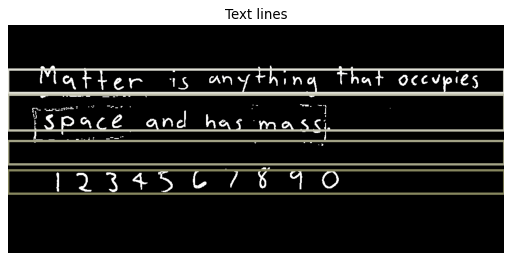

(500, 1087)


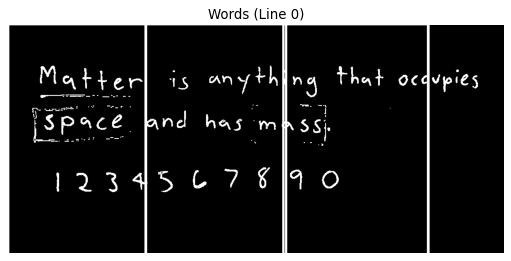

(500, 1087)


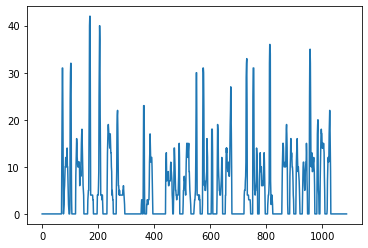

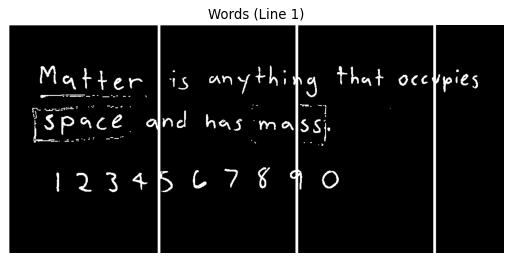

(500, 1087)


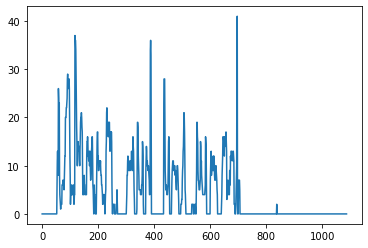

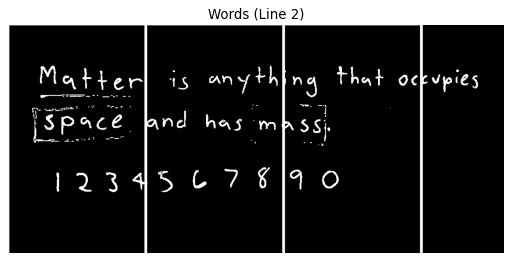

(500, 1087)


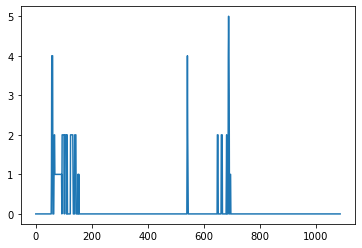

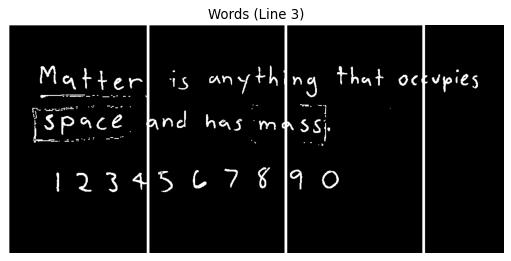

HORIZONTAL HISTOGRAM
Lines:
 [[ 99 150]
 [154 232]
 [255 306]
 [319 370]]
Words:
 [array([[  0, 301],
       [302, 603],
       [609, 920],
       [921,  -1]]), array([[  0, 330],
       [331, 632],
       [633, 934],
       [935,  -1]]), array([[  0, 301],
       [302, 603],
       [604, 905],
       [906,  -1]]), array([[  0, 306],
       [307, 608],
       [609, 910],
       [911,  -1]])]


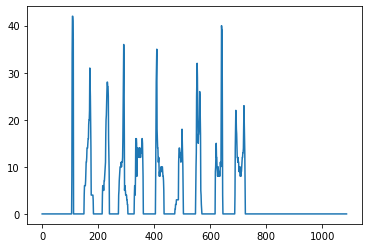

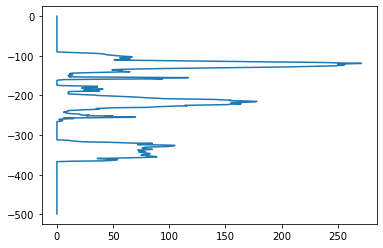

In [89]:
def hhp(img):
    horizontal_hist = np.sum(img, axis=1, keepdims=True) / 255
    x = [h for h in range(0,-1*(len(horizontal_hist)),-1)]
    y = []
    #print(len(horizontal_hist))
    for f in horizontal_hist:
        for g in f:
            y.append(g)
    #y.reverse()
#     print(x)
#     print(horizontal_hist)
    plt.figure(0)
    plt.plot(y, x)
    

def vhp(img):
    vertical_hist = np.sum(img,axis=0,keepdims=True)/255
    x = [h for h in range(0,np.size(vertical_hist))]
    y = []
    for f in vertical_hist:
        for g in f:
            y.append(g)
    #y.reverse()
    plt.figure(1)
    plt.plot(x, y)
    
# hhp(annotations_img)
# vhp(text_img)

# hhp(text_img)
# vhp(text_img)

#############################################################################

# THRESHOLDS:
LINE_PIXEL_MIN = 50
LINE_HEIGHT_MIN = 50

WORD_PIXEL_THRESH = 30
WORD_SPACE_MIN = 10
WORD_SPACE_MAX = 20
CHAR_THRESH = 1

def plot_h_hist(h_hist, fig_id):
    x = [h for h in range(0, -1*(len(h_hist)), -1)]
    plt.figure(fig_id)
    plt.plot(h_hist, x)
    
def plot_v_hist(v_hist, fig_id):
    x = [h for h in range(np.size(v_hist))]
    plt.figure(fig_id)
    plt.plot(x, v_hist)


# Method:
# divide image into lines
# divide lines into words
# divide words to characters

def horizontal_hist(img):
    return np.sum(img, axis=1, keepdims=True) / 255

def vertical_hist(img):
    return np.sum(img, axis=0, keepdims=True) / 255


# divide to lines
def find_lines(h_hist, img):
    y = []
    is_start = True
    for i in range(len(h_hist)):
        if h_hist[i] > LINE_PIXEL_MIN:
            if is_start:
                y.append([i, -1])
                is_start = False
        elif not is_start and i - y[-1][0] > LINE_HEIGHT_MIN:
            y[-1][1] = i
            is_start = True
    y = np.array(y)
    lined_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    color = (255, 255, 255)
    print(img.shape)
    for line in y:
        print((0, line[0]), (img.shape[1], line[1]))
        color = (color[0] - 30, color[1] - 30, color[2] - 40)
        lined_img = cv2.rectangle(lined_img, (0, line[0]), (img.shape[1], line[1]), color, 4)
    utils.plot_img_rgb(lined_img, "Text lines")
    return y



# divide to words
def find_words(lines, img):
    words = []
    fig_id = 0
    for line in lines:
        start_y = line[0] 
        end_y = line[1]
        line_v_hist = vertical_hist(img[start_y:end_y+1,:]).flatten()
        
        # copied from find_lines, adjusted a few things
        x = []
        is_start = True 
        for i in range(len(line_v_hist)):
            if line_v_hist[i] == 0: # temporary value
                if is_start:
                    x.append([i, -1])
                    is_start = False
                elif not is_start and i - x[-1][0] > 300: # temporary value
                    x[-1][1] = i
                    is_start = True
        x = np.array(x)
        worded_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        color = (255, 255, 255)
        print(img.shape)
        for word in x:
            # print((word[0], 0), (word[1], img.shape[1]))
            color = (color[0] - 30, color[1] - 30, color[2] - 40)
            worded_img = cv2.rectangle(worded_img, (word[0], 0), (word[1], img.shape[1]), (255, 255, 255), 4)
        utils.plot_img_rgb(worded_img, "Words (Line {})".format(fig_id))
        
        words.append(x)
    
        
        plot_v_hist(line_v_hist, fig_id)
        fig_id += 1
    
    return words
    


# divide to characters
def find_chars(words, v_hist):
    pass


class Text:
    def __init__(self, img):
        self.img = img
        self.img_df = pd.DataFrame(self.img)
        self.shape = img.shape
        
        self.h_hist = horizontal_hist(img).flatten()
        self.lines = find_lines(self.h_hist, self.img)
        self.words = find_words(self.lines, self.img)
        self.chars = []

test_text_1 = Text(text_img)


print("HORIZONTAL HISTOGRAM")
plot_h_hist(test_text_1.h_hist, 10)
print("Lines:\n", test_text_1.lines)
print("Words:\n", test_text_1.words)




## Annotations Segmentation